In [16]:
%run Module-2-helper.py

### For Visualization, 2-D PCA transfer the data

In [27]:
# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT = './simulated-data-transformed' 
BEGIN_DATE = "2022-01-15"
END_DATE = "2022-04-20"
print("Load  files")
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.Trans_FRAUD.sum()))
output_feature = "Trans_FRAUD"
input_features = ['Trans_AMOUNT','Trans_DURING_WEEKEND', 'Trans_DURING_NIGHT', 'CUSTOMER_ID_NB_Trans_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_Trans_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'STORE_ID_NB_Trans_1DAY_WINDOW',
       'STORE_ID_RISK_1DAY_WINDOW', 'STORE_ID_NB_Trans_7DAY_WINDOW',
       'STORE_ID_RISK_7DAY_WINDOW', 'STORE_ID_NB_Trans_30DAY_WINDOW',
       'STORE_ID_RISK_30DAY_WINDOW']

Load  files
2323689 transactions loaded, containing 28085 fraudulent transactions


In [29]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
x = transactions_df.loc[:, input_features].values
# Separating out the target
y = transactions_df.loc[:,['Trans_FRAUD']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [32]:
finalDf = pd.concat([principalDf, transactions_df[['Trans_FRAUD']]], axis = 1)

In [39]:
dataset_df = finalDf.rename(columns={"principal component 1" : "X1", "principal component 2" : "X2", "Trans_FRAUD": "Y"})

In [47]:
dataset_df

,X1,X2,Y
0,-2.603050,-2.787672,0
1,2.964918,-0.523326,0
2,-3.068767,-3.056342,0
3,2.441209,-1.895311,0
4,-2.183462,-0.633558,0
...,...,...,...
2323684,0.847092,1.097524,0
2323685,0.534685,1.877737,0
2323686,0.477369,1.143789,0
2323687,-2.723357,1.631917,0


In [50]:
X, y = dataset_df[["X1", "X2"]], dataset_df[["Y"]]

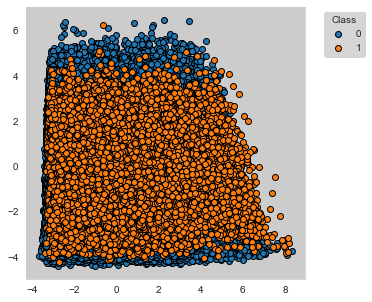

In [51]:
fig_distribution, ax = plt.subplots(1, 1, figsize=(5,5))

groups = dataset_df.groupby('Y')
for name, group in groups:
    ax.scatter(group.X1, group.X2, edgecolors='k', label=name,alpha=1,marker='o')
    
ax.legend(loc='upper left', 
          bbox_to_anchor=(1.05, 1),
          title="Class")

## Decision-Trees - Tacking Imbalance using the Cost-Sensitive Learning
---

In [52]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight={0:1,1:1},random_state=0)
cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [53]:
cv_results_ = sklearn.model_selection.cross_validate(classifier, X, y, cv=cv,
                                                     scoring=['roc_auc',
                                                              'average_precision',
                                                              'balanced_accuracy'],
                                                     return_estimator=True)

In [54]:
results = round(pd.DataFrame(cv_results_),3)
results

,fit_time,score_time,estimator,test_roc_auc,test_average_precision,test_balanced_accuracy
0,3.120,0.190,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.532,0.036,0.507
1,3.007,0.207,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.535,0.038,0.506
2,3.004,0.156,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.535,0.040,0.508
3,3.018,0.183,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.536,0.040,0.504
4,3.106,0.190,"DecisionTreeClassifier(class_weight={0: 1, 1: ...",0.535,0.040,0.507


In [55]:
results_mean = list(results.mean().values)
results_std = list(results.std().values)

pd.DataFrame([[str(round(results_mean[i],3))+'+/-'+str(round(results_std[i],3)) for i in range(len(results))]],
            columns=['Fit time (s)','Score time (s)','AUC ROC','Average Precision','Balanced accuracy'])

/var/folders/vb/1nttnwc116l2y0t3v_x1pqqc0000gn/T/ipykernel_9109/3263762727.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/var/folders/vb/1nttnwc116l2y0t3v_x1pqqc0000gn/T/ipykernel_9109/3263762727.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
0,3.051+/-0.057,0.185+/-0.019,0.535+/-0.002,0.039+/-0.002,0.506+/-0.002


In [56]:
classifier_0 = cv_results_['estimator'][0]

In [57]:
# Retrieve the indices used for the training and testing of the first fold of the cross-validation
(train_index, test_index) = next(cv.split(X, y))

# Recreate the train and test DafaFrames from these indices
train_df = pd.DataFrame({'X1':X[train_index,0], 'X2':X[train_index,1], 'Y':y[train_index]})
test_df = pd.DataFrame({'X1':X[test_index,0], 'X2':X[test_index,1], 'Y':y[test_index]})
input_features = ['X1','X2', 'X3']
output_feature = 'Y'

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 142, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(array([      0,       1,       2, ..., 2323685, 2323686, 2323687]), 0)' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/vb/1nttnwc116l2y0t3v_x1pqqc0000gn/T/ipykernel_9109/3277603477.py", line 5, in <cell line: 5>
    train_df = pd.DataFrame({'X1':X[train_index,0], 'X2':X[train_index,1], 'Y':y[train_in

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


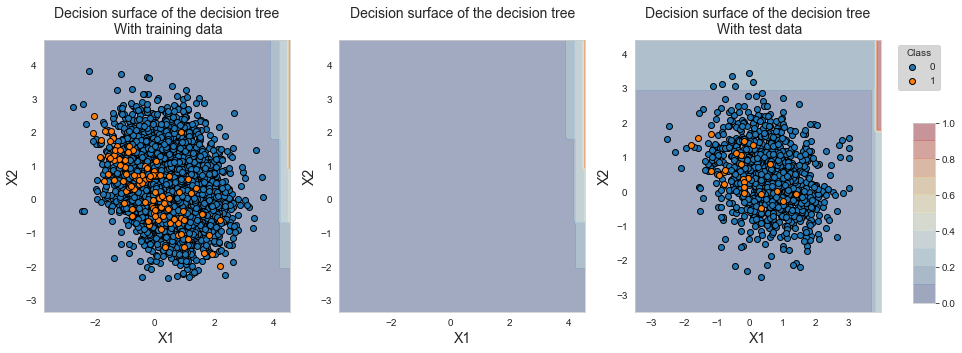

In [58]:
fig_decision_boundary, ax = plt.subplots(1, 3, figsize=(5*3,5))

plot_decision_boundary_classifier(ax[0], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n With training data",
                                  plot_training_data=True)

plot_decision_boundary_classifier(ax[1], classifier_0,
                                  train_df,
                                  title="Decision surface of the decision tree\n",
                                  plot_training_data=False)


plot_decision_boundary_classifier(ax[2], classifier_0,
                                  test_df,
                                  title="Decision surface of the decision tree\n With test data",
                                  plot_training_data=True)

ax[-1].legend(loc='upper left', 
              bbox_to_anchor=(1.05, 1),
              title="Class")

sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlBu_r, norm=plt.Normalize(vmin=0, vmax=1))
cax = fig_decision_boundary.add_axes([0.93, 0.15, 0.02, 0.5])
fig_decision_boundary.colorbar(sm, cax=cax, alpha=0.3, boundaries=np.linspace(0, 1, 11))

In [59]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight={0:1,1:1},random_state=0)


(results_df_dt_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                                     X, y, 
                                                                                     n_splits=5,
                                                                                     strategy_name="Decision tree - Baseline")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:662: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:663: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 142, in pandas._libs.index.IndexEngine.get_loc
TypeError: '(array([      0,       1,       2, ..., 2323685, 2323686, 2323687]), 0)' is an invalid key

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/vb/1nttnwc116l2y0t3v_x1pqqc0000gn/T/ipykernel_9109/4023104771.py", line 4, in <cell line: 4>
    (results_df_dt_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(

### Adding Cost-Sensitive

In [18]:
IR=0.05/0.95
class_weight={0:IR,1:1}

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:662: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:663: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


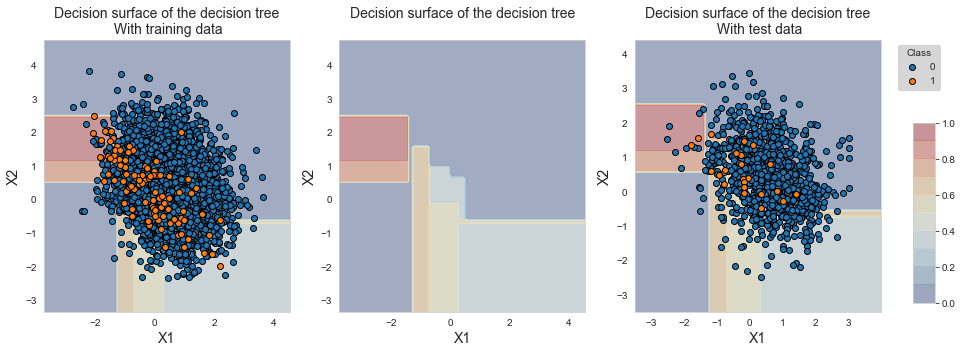

In [19]:
classifier = sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight=class_weight,random_state=0)

(results_df_dt_cost_sensitive, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                         X, y, 
                                                                         n_splits=5,
                                                                         strategy_name="Decision tree - Cost-sensitive")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [20]:
pd.concat([results_df_dt_baseline, 
           results_df_dt_cost_sensitive])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.003+/-0.001,0.001+/-0.0,0.709+/-0.048,0.063+/-0.013,0.499+/-0.001
Decision tree - Cost-sensitive,0.003+/-0.0,0.001+/-0.0,0.652+/-0.074,0.061+/-0.021,0.602+/-0.039


# Same for the Logistic Regreesion 

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:662: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:663: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


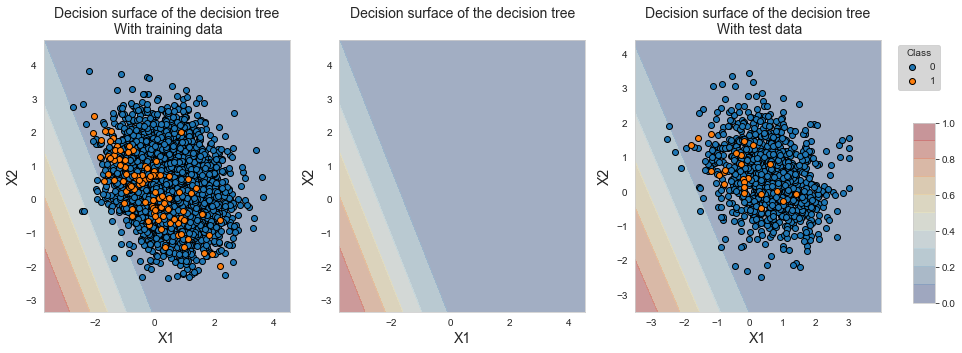

In [21]:
classifier = sklearn.linear_model.LogisticRegression(C=1,class_weight={0:1,1:1},random_state=0)

(results_df_lr_baseline, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                          X, y, 
                                                                          n_splits=5,
                                                                          strategy_name="Logistic regression - Baseline")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [22]:
results_df_lr_baseline

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.003+/-0.001,0.001+/-0.0,0.752+/-0.033,0.074+/-0.018,0.5+/-0.0


### Adding Cost-Sensitive

/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:662: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_mean = list(results.mean().values)
/Users/dayevan/Desktop/Final-Module-2/Module-2-helper.py:663: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  results_std = list(results.std().values)


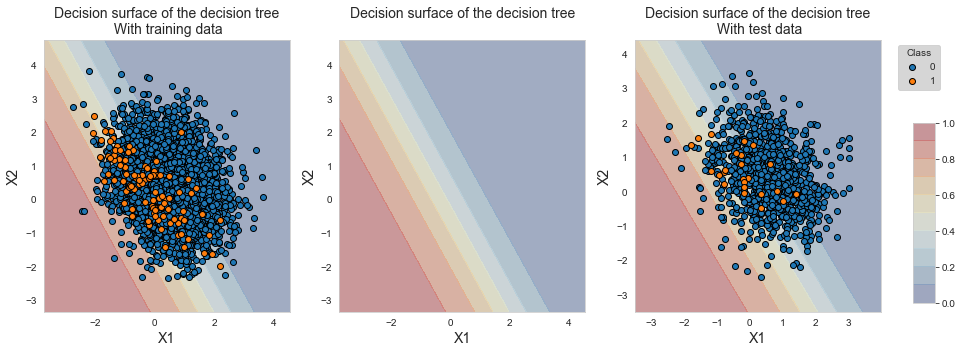

In [23]:
classifier = sklearn.linear_model.LogisticRegression(C=1,class_weight={0:IR,1:1},random_state=0)

(results_df_lr_cost_sensitive, classifier_0, train_df, test_df) = kfold_cv_with_classifier(classifier, 
                                                                         X, y, 
                                                                         n_splits=5,
                                                                         strategy_name="Logistic regression - Cost-sensitive")

fig_decision_boundary = plot_decision_boundary(classifier_0, train_df, test_df)

In [24]:
pd.concat([results_df_lr_baseline, results_df_lr_cost_sensitive])

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Logistic regression - Baseline,0.003+/-0.001,0.001+/-0.0,0.752+/-0.033,0.074+/-0.018,0.5+/-0.0
Logistic regression - Cost-sensitive,0.002+/-0.0,0.001+/-0.0,0.759+/-0.029,0.066+/-0.014,0.623+/-0.027


In [25]:
results_df = pd.concat([results_df_dt_baseline,
                        results_df_dt_cost_sensitive,
                        results_df_lr_baseline,
                        results_df_lr_cost_sensitive])
results_df

,Fit time (s),Score time (s),AUC ROC,Average Precision,Balanced accuracy
Decision tree - Baseline,0.003+/-0.001,0.001+/-0.0,0.709+/-0.048,0.063+/-0.013,0.499+/-0.001
Decision tree - Cost-sensitive,0.003+/-0.0,0.001+/-0.0,0.652+/-0.074,0.061+/-0.021,0.602+/-0.039
Logistic regression - Baseline,0.003+/-0.001,0.001+/-0.0,0.752+/-0.033,0.074+/-0.018,0.5+/-0.0
Logistic regression - Cost-sensitive,0.002+/-0.0,0.001+/-0.0,0.759+/-0.029,0.066+/-0.014,0.623+/-0.027
